# Parity RNN Training

In this notebook, we'll train a Parity RNN, in the hopes of replicating a sharp phase transition from random performance to perfect generalization.

### 1. Imports

In [1]:
import torch
import torch.nn as nn
import os, sys
import re
import numpy as np
import glob
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# Add project root (one level up) to Python path 
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from models.parity_rnn import ParityRNN
from torch.nn.utils.rnn import pack_sequence, pad_packed_sequence

torch.manual_seed(42)

### 2. Parameters & Loading Data

In [2]:
hidden_size = 100       # number of hidden ReLU units
input_size = 2          # one-hot binary input
output_size = 2         # one-hot parity output
learning_rate = 0.05    # SGD learning rate
batch_size = 128        # training batch size
num_epochs = 1000       # number of training epochs
clip_norm = None        # no gradient clipping
VAL_SEQ_LEN = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ParityRNN(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.0, weight_decay=0.0)
criterion = nn.MSELoss()


In [3]:
train_data = np.load('../data/training/train_data.npz', allow_pickle=True)
train_seqs = train_data['X']
train_labels = train_data['Y']
train_losses = []

val_files = glob.glob(os.path.join("../data/validation/", 'val_data_*.npz'))
val_files = sorted(
    val_files,
    key=lambda p: int(re.search(r'(\d+)(?=\.npz$)', os.path.basename(p)).group(1))
)
val_numbers = [int(re.search(r'(\d+)(?=\.npz$)', os.path.basename(p)).group(1)) for p in val_files]

val_data = [np.load(f, allow_pickle=True) for f in val_files]
val_seqs = [d['X'] for d in val_data] 
val_labels = [d['Y'] for d in val_data]
val_losses = []

### 3. One-Hot Encodings

In [4]:
def one_hot_seq(seq):
    tens = []
    for bits in seq:
        L = len(bits)
        t = torch.zeros(L, input_size)
        for i, b in enumerate(bits):
            t[i, b] = 1.0
        tens.append(t)
    return tens

In [5]:
train_tensors = one_hot_seq(train_seqs)
train_labels_tensor = torch.LongTensor(train_labels)

val_tensors = [one_hot_seq(val_seq) for val_seq in val_seqs]
val_labels_tensor = [torch.LongTensor(val_label) for val_label in val_labels]

### 4. Training and Validation functions

In [6]:
def train_parity_rnn(n):
  model.train()
  total_train_loss = 0.0

  perm = torch.randperm(n)
  for i in range(0, n, batch_size):
      idx = perm[i : i+batch_size]
      batch_xs = [train_tensors[j].to(device) for j in idx.tolist()]
      batch_labels = train_labels_tensor[idx].to(device)

      packed_x = pack_sequence(batch_xs, enforce_sorted=False).to(device)

      logits, _ = model(packed_x)
        
      target = torch.zeros_like(logits)
      target[torch.arange(logits.size(0)), batch_labels] = 1.0

      loss = criterion(logits, target)

      optimizer.zero_grad()
      loss.backward()

      clip_value = 0.5
      torch.nn.utils.clip_grad_value_(model.parameters(), clip_value)

      optimizer.step()

      total_train_loss += loss.item() * batch_labels.size(0)

  return total_train_loss

In [7]:
def validate_model_optimized():
    """Optimized validation maintaining separate results per sequence length"""
    model.eval()
    
    results = {
        'losses': [],
        'accuracies': [],
    }
    
    with torch.no_grad():
        for val_idx, (val_tensor_list, val_label_tensor) in enumerate(zip(val_tensors, val_labels_tensor)):
            total_loss = 0.0
            correct = 0
            
            seq_length = val_numbers[val_idx]
            if seq_length <= 25:
                batch_size_val = 100  
            elif seq_length <= 50:
                batch_size_val = 50   
            else:
                batch_size_val = 25  
            
            for i in range(0, 100, batch_size_val):
                end_idx = min(i + batch_size_val, 100)
                batch_xs = [val_tensor_list[j].to(device) for j in range(i, end_idx)]
                batch_labels = val_label_tensor[i:end_idx].to(device)
                
                packed_x = pack_sequence(batch_xs, enforce_sorted=False)
                logits, _ = model(packed_x)
                
                target = torch.zeros_like(logits)
                target.scatter_(1, batch_labels.unsqueeze(1), 1.0)
                
                loss = criterion(logits, target)
                total_loss += loss.item() * len(batch_labels)
                correct += (torch.argmax(logits, dim=1) == batch_labels).sum().item()
            
            results['losses'].append(total_loss) 
            results['accuracies'].append(correct)
    
    return results

In [8]:
def print_val_summary(avg_val_loss, val_accuracy):
    """Efficient one-liner using list comprehension"""
    return ' '.join([
        f"| Val({val_numbers[i]}) - Loss: {loss:.4f} & Acc: {acc:.3f}"
        for i, (loss, acc) in enumerate(zip(avg_val_loss, val_accuracy))
    ])

In [9]:
# Comment out if there is a saved model

"""
n = len(train_seqs)
m = VAL_SEQ_LEN

for epoch in range(1,1001):
    total_train_loss = train_parity_rnn(n)
    val_results = validate_model_optimized()
    total_val_loss, correct = val_results['losses'], val_results['accuracies']
    avg_train_loss = total_train_loss / n
    train_losses.append((avg_train_loss, epoch))
    avg_val_loss = [l / m for l in total_val_loss]
    val_losses.append([(avl, epoch) for avl in avg_val_loss])
    val_accuracy = [c / m for c in correct]
    if epoch % 10 == 0:
        print(f"Epoch {epoch:4d} | Train Loss: {avg_train_loss:.4f} {print_val_summary(avg_val_loss, val_accuracy)}")
"""

# Comment out if there is no saved model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ParityRNN(input_size=2, hidden_size=100, output_size=2).to(device)
checkpoint = torch.load('../models/checkpoints/parity_rnn_checkpoint.pt', map_location=device)

train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']

/var/folders/4z/s244bv2s5f7g8mctfr_jt3sc0000gn/T/ipykernel_32070/1401339756.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../models/checkpoin

### 5. Recreating Figure 1 and Figure 6

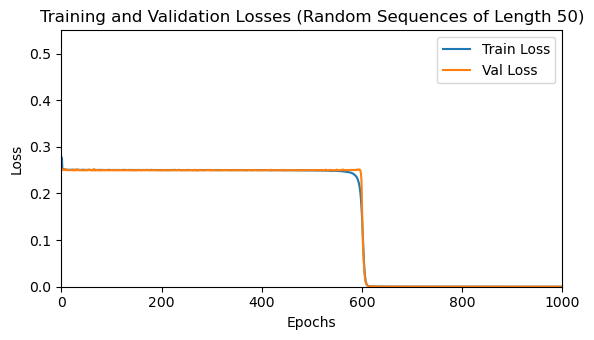

In [13]:
import matplotlib.pyplot as plt

# Specifically using validation set of length 50

train_losses_array = np.array(train_losses)
val_losses_array = np.array([v[1] for v in val_losses])

train_epochs = train_losses_array[:, 1]
train_values = train_losses_array[:, 0]

val_epochs = val_losses_array[:, 1]
val_values = val_losses_array[:, 0]

plt.figure(figsize=(6, 3.5))
plt.plot(train_epochs, train_values, label="Train Loss")
plt.plot(val_epochs, val_values, label="Val Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xlim(0, 1000)
plt.ylim(0, 0.55)
plt.title("Training and Validation Losses (Random Sequences of Length 50)")


plt.legend()
plt.tight_layout()

plt.savefig('../figures/figure_1.png', 
            dpi=300, 
            bbox_inches='tight', 
            facecolor='white')
plt.show()

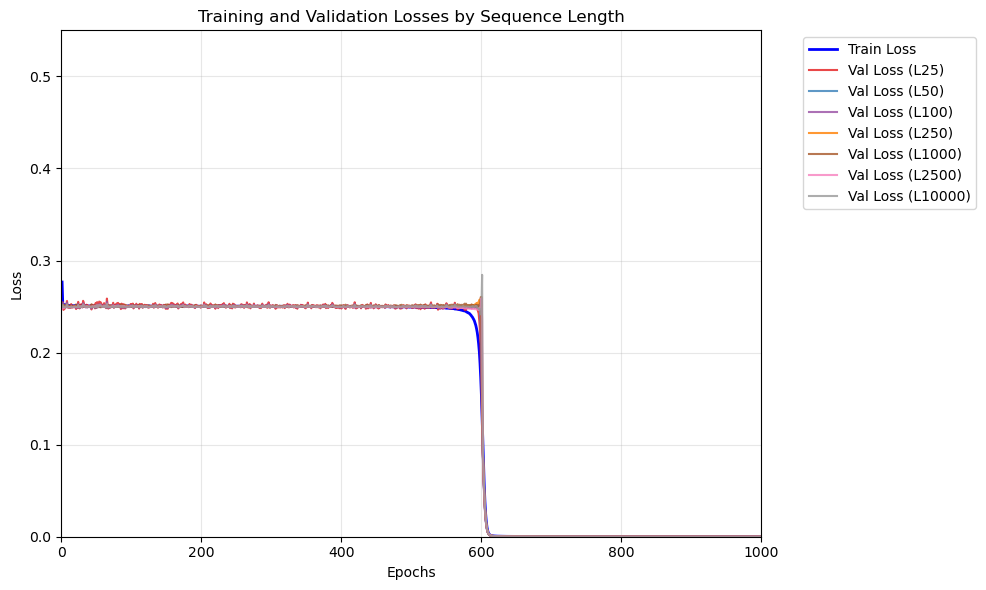

In [15]:
# using ALL validation sets

train_losses_array = np.array(train_losses)
train_epochs = train_losses_array[:, 1]
train_values = train_losses_array[:, 0]

val_losses_by_length = {}

for epoch_idx, epoch_val_data in enumerate(val_losses):
    epoch_num = epoch_idx + 1  
    
    for val_idx, (val_loss, _) in enumerate(epoch_val_data):
        length = val_numbers[val_idx]
        
        if length not in val_losses_by_length:
            val_losses_by_length[length] = {'epochs': [], 'losses': []}
        
        val_losses_by_length[length]['epochs'].append(epoch_num)
        val_losses_by_length[length]['losses'].append(val_loss)

plt.figure(figsize=(10, 6))

plt.plot(train_epochs, train_values, label="Train Loss", linewidth=2, color='blue')

colors = plt.cm.Set1(np.linspace(0, 1, len(val_numbers)))  

for i, length in enumerate(sorted(val_numbers)):
    if length in val_losses_by_length:
        epochs = val_losses_by_length[length]['epochs']
        losses = val_losses_by_length[length]['losses']
        plt.plot(epochs, losses, 
                label=f"Val Loss (L{length})", 
                linewidth=1.5, 
                color=colors[i],
                alpha=0.8)

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xlim(0, 1000)
plt.ylim(0, 0.55)
plt.title("Training and Validation Losses by Sequence Length")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('../figures/figure_6.png', 
            dpi=300, 
            bbox_inches='tight', 
            facecolor='white')
plt.show()

In [12]:
"""
checkpoint = {
    "epoch": epoch,
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "train_losses": train_losses,
    "val_losses": val_losses,
}
torch.save(checkpoint, "../models/checkpoints/parity_rnn_checkpoint.pt")
"""

'\ncheckpoint = {\n    "epoch": epoch,\n    "model_state": model.state_dict(),\n    "optimizer_state": optimizer.state_dict(),\n    "train_losses": train_losses,\n    "val_losses": val_losses,\n}\ntorch.save(checkpoint, "../models/checkpoints/parity_rnn_checkpoint.pt")\n'